# Long-run Interest Rate

## Motivation

In [37]:
import pandas_datareader.data as web
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [38]:
country_code = {'US': 'US',
                      'Germany': 'DE',
                      'Japan': 'JP',
                      'UK': 'GB',
                      'France': 'FR'}


item_code = {'M3_rate': 'IR3TIB01__M156N',
             'CPI': 'CPALTT01__M659N'}

In [39]:
# Read all available data for future use
start = datetime.datetime(1950, 1, 1)
end = datetime.datetime(2024, 1, 1)

# Create a dictionary of item codes and country names
M3_item_codes = {item_code['M3_rate'].replace(
                  '__', country_code[country]): country
                  for country in country_code.keys()}

CPI_codes = {item_code['CPI'].replace(
             '__', country_code[country]): country 
             for country in country_code.keys()}

# Read data from FRED
M3_rate_df = web.DataReader(M3_item_codes.keys(), 'fred', start, end)
CPI_df = web.DataReader(CPI_codes.keys(), 'fred', start, end)

# Rename columns
M3_rate_df.rename(columns=M3_item_codes, 
                           inplace=True)

CPI_df.rename(columns=CPI_codes, 
              inplace=True)

# Save data in case API fails
M3_rate_df.to_csv('data/3-month_rate.csv')
CPI_df.to_csv('data/CPI.csv')

In [40]:
M3_rate_df = pd.read_csv('data/3-Month_rate.csv', parse_dates=True)
CPI_df = pd.read_csv('data/CPI.csv', parse_dates=True)

M3_rate_df.set_index('DATE', inplace=True)
CPI_df.set_index('DATE', inplace=True)

# shift -2 of rolling average to align with the current month
cpi_rolling_avg = CPI_df.rolling(window=3).mean().shift(-3)

real_df = M3_rate_df.join(cpi_rolling_avg, lsuffix='_rate', rsuffix='_cpi_avg')

# Compute real interest rate
for country in country_code.keys():
    real_df[f'{country}_real_interest'] = (real_df[f'{country}_rate'] 
                                          - real_df[f'{country}_cpi_avg'])

In [41]:
def generate_historical_plot(real_df, codes, start, title, figsize, end=-1):

    if not isinstance(real_df.index, pd.DatetimeIndex):
        real_df.index = pd.to_datetime(real_df.index)

    if end == -1:
        end = real_df.index[-1]

    # Filter the dataframe to the desired time period
    filtered_df = real_df.loc[start:end]

    adjusted_df = filtered_df.copy()
    adjusted_df['Month_Year'] = adjusted_df.index.strftime('%b %Y')

    plt.figure(figsize=figsize, dpi=400)

    # Plotting real interest rates
    for country in codes:
        plt.plot(adjusted_df['Month_Year'], adjusted_df[f'{country}_real_interest'], label=country, lw=2, alpha=0.8)

    # Adding a horizontal line at 0
    plt.axhline(0, color='gray')

    # Customizing the plot
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False) 
    plt.xticks(rotation=45)
    x_ticks = np.linspace(start=0, stop=len(adjusted_df['Month_Year']) - 1, num=5, dtype=int)
    plt.xticks(ticks=adjusted_df['Month_Year'].iloc[x_ticks], labels=adjusted_df['Month_Year'].iloc[x_ticks])
    plt.box(False)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

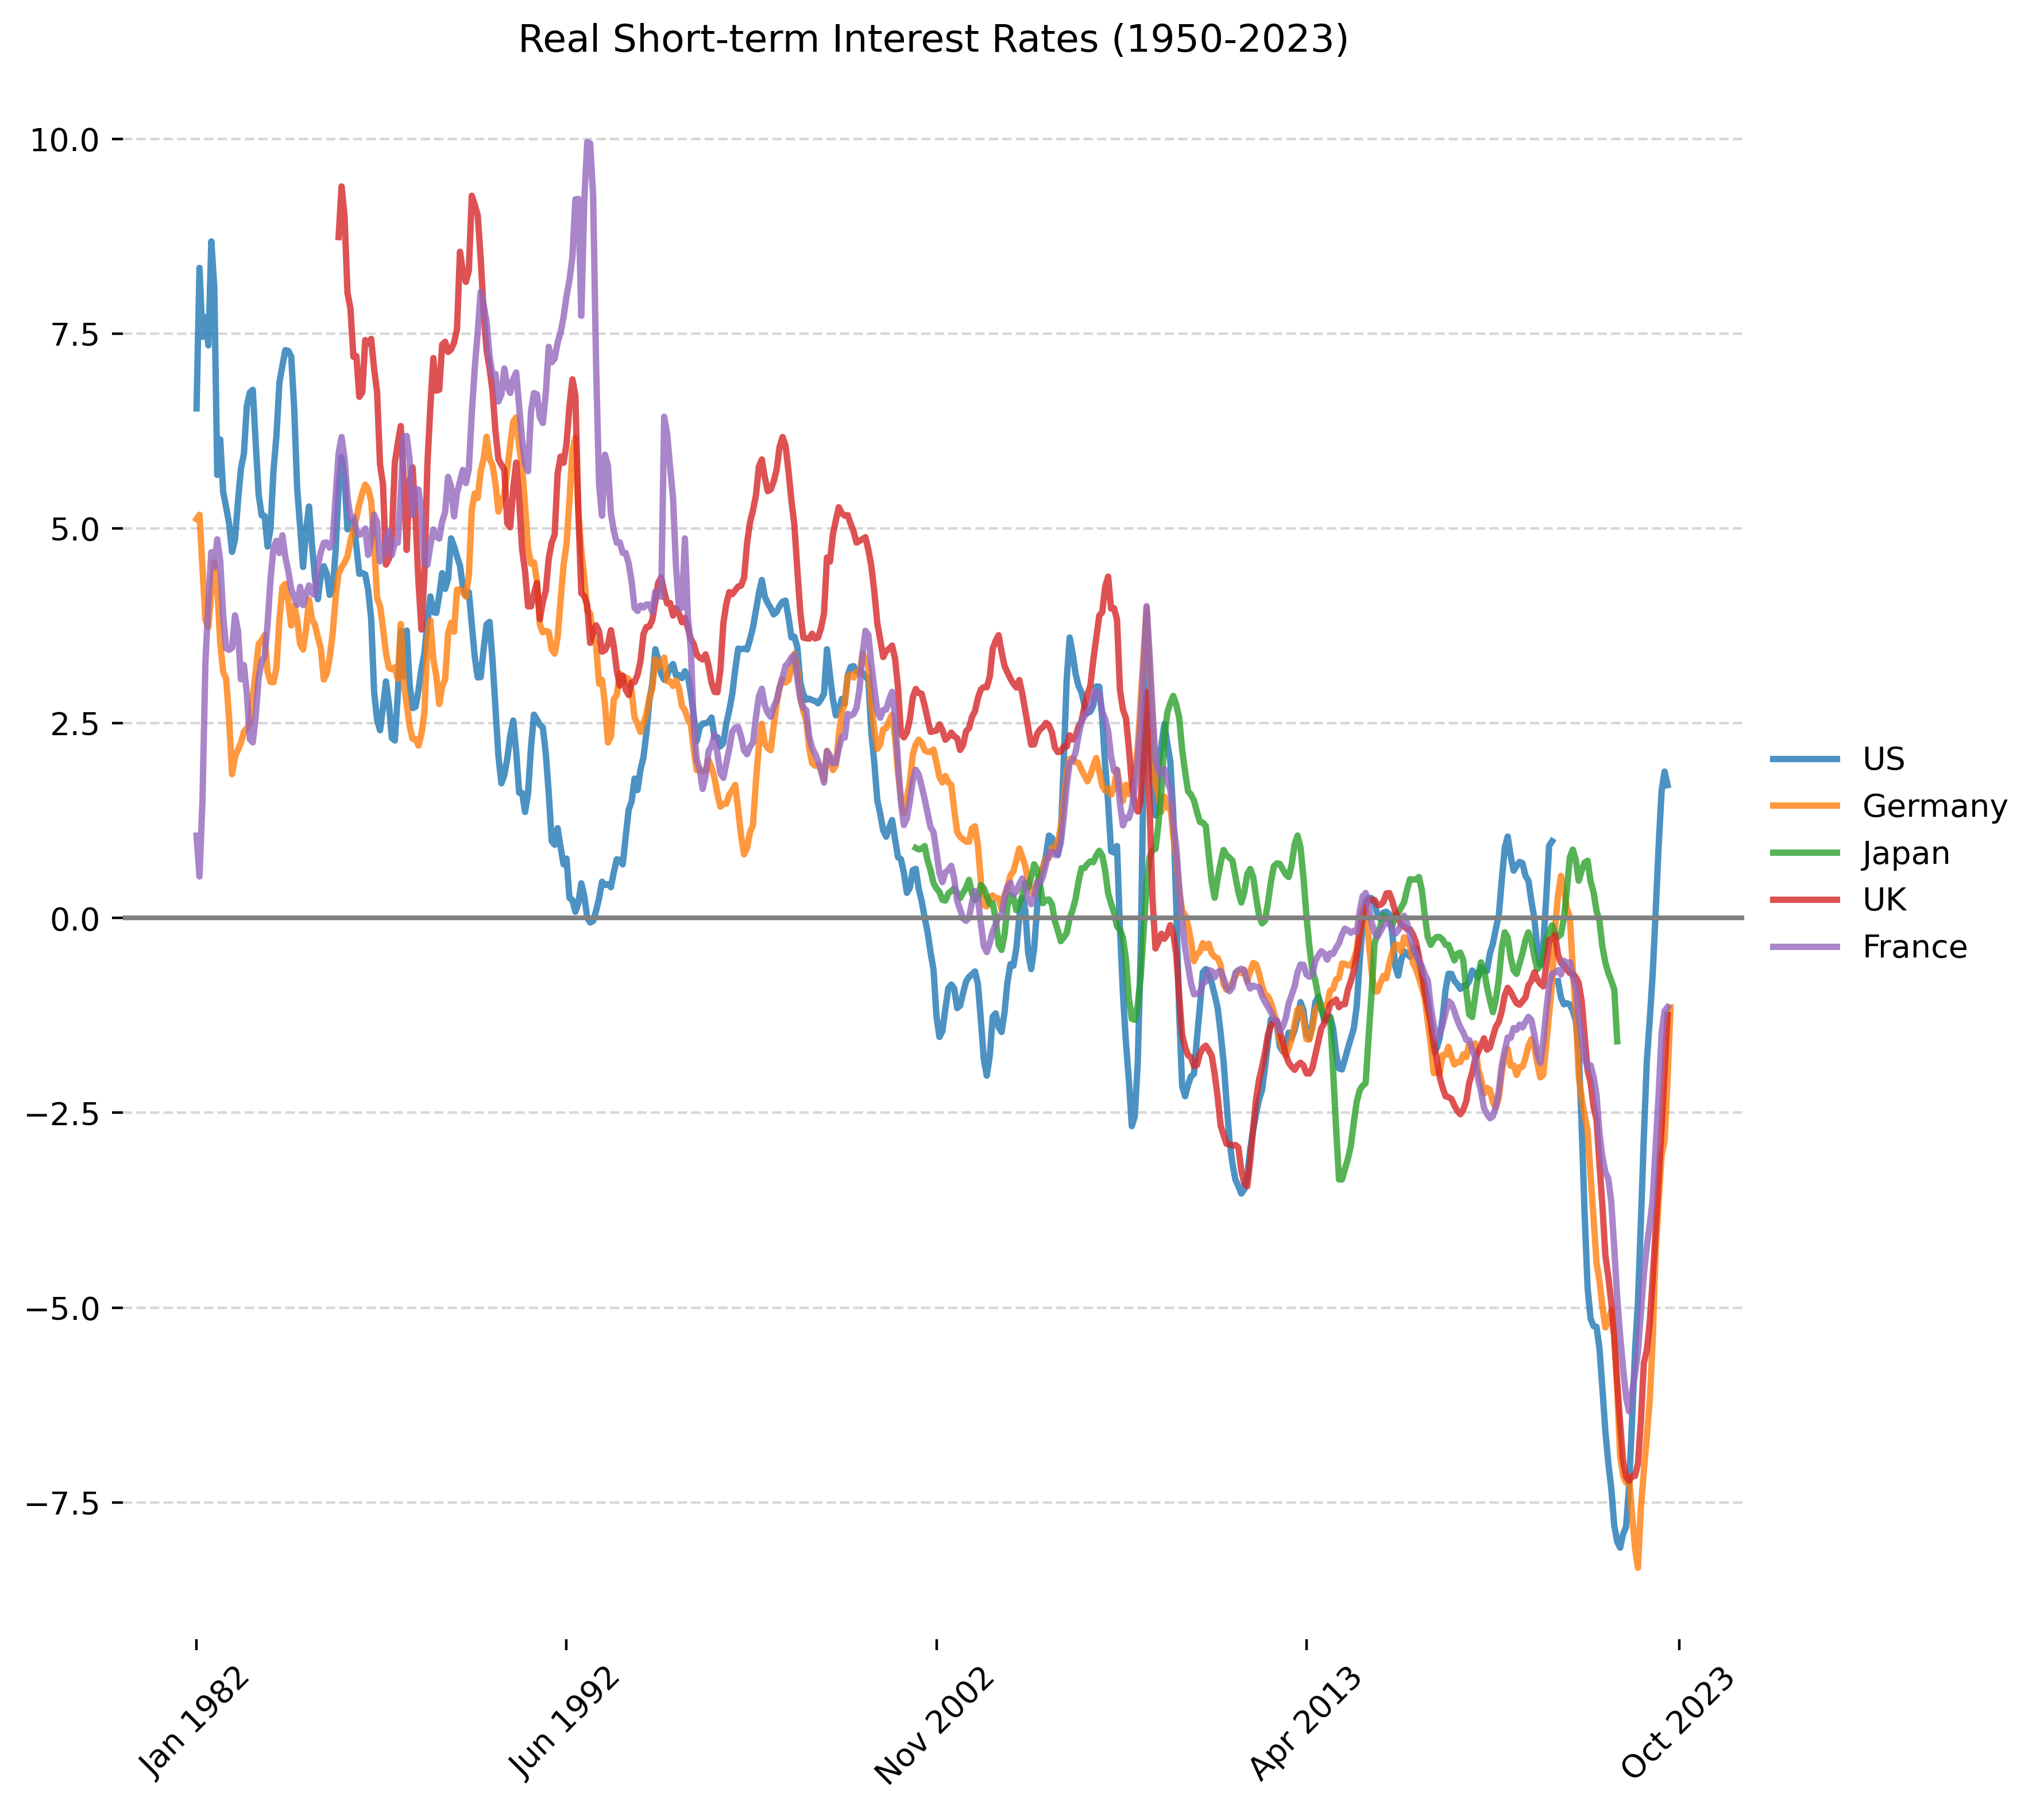

In [42]:
generate_historical_plot(real_df, country_code.keys(), '1982-01-01', 'Real Short-term Interest Rates (1950-2023)', figsize=(9, 8))

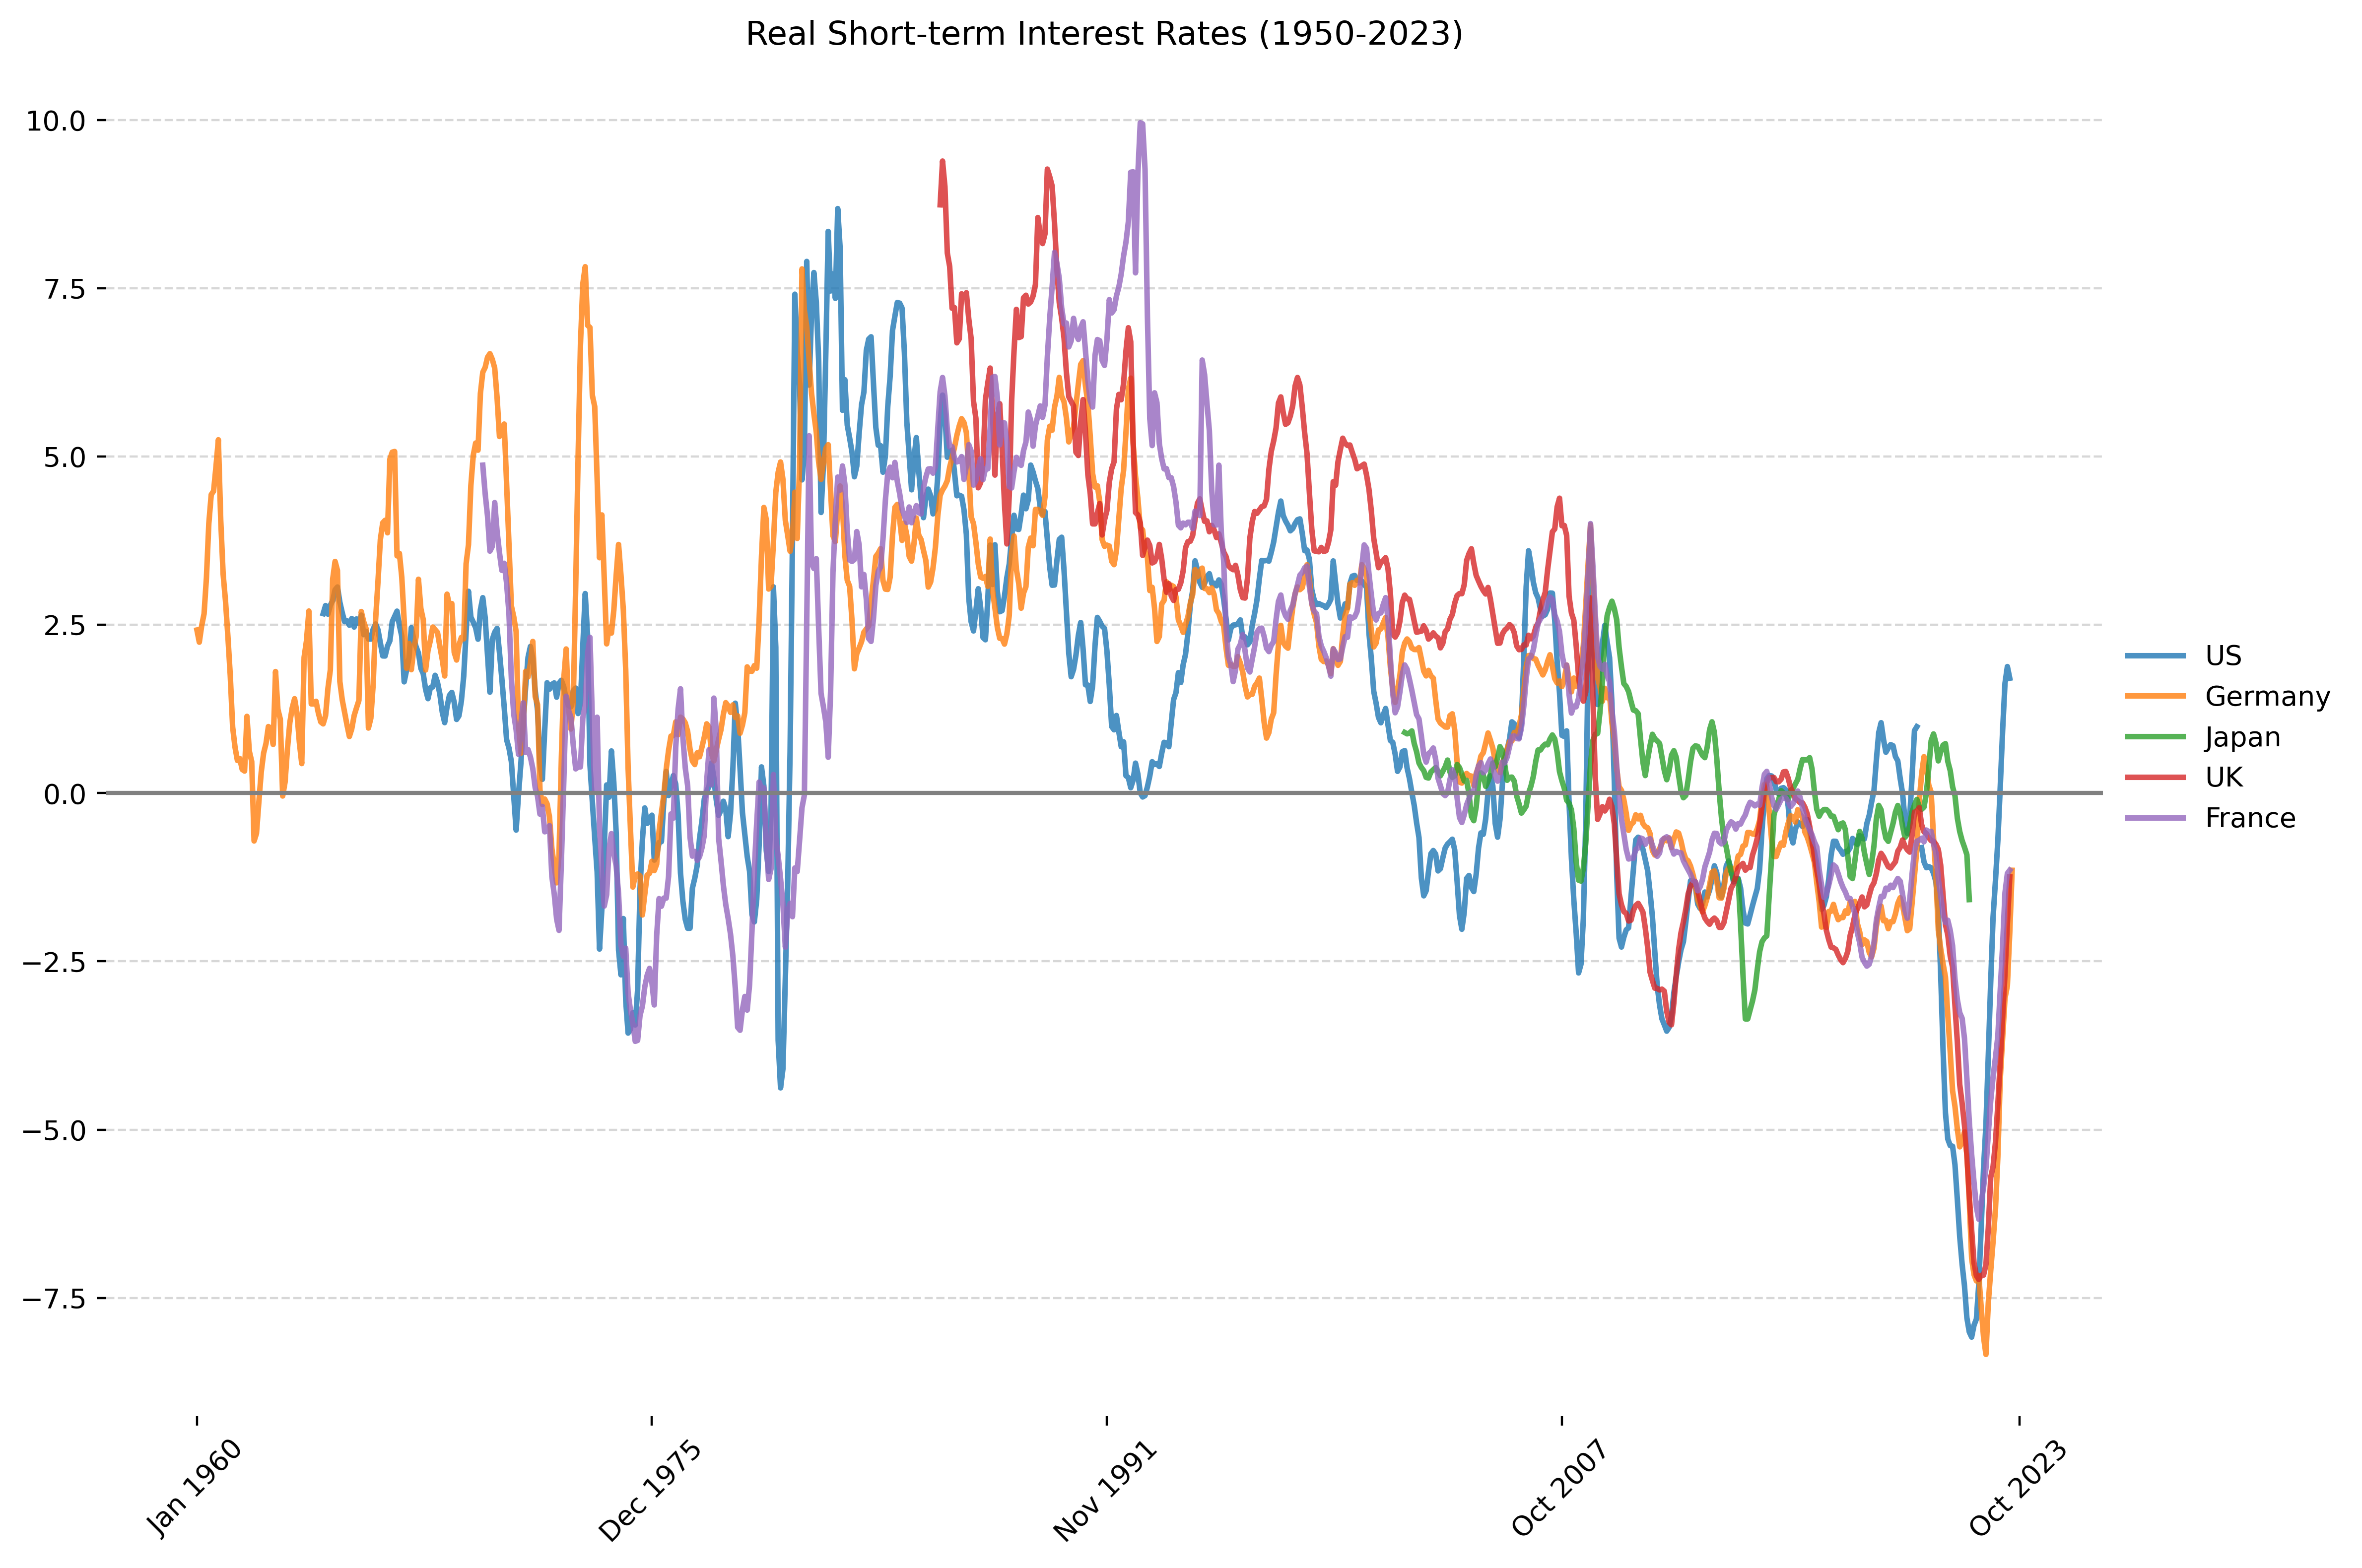

In [43]:
generate_historical_plot(real_df, country_code.keys(), '1950-01-01', 'Real Short-term Interest Rates (1950-2023)', figsize=(12, 8))

In [44]:
def generate_single_series(real_df, start, title, figsize, end=-1):

    if not isinstance(real_df.index, pd.DatetimeIndex):
            real_df.index = pd.to_datetime(real_df.index)

    if end == -1:
        end = real_df.index[-1]

    # Filter the dataframe to the desired time period
    filtered_df = real_df.loc[start:end]

    adjusted_df = filtered_df.copy()
    adjusted_df['Month_Year'] = adjusted_df.index.strftime('%b %Y')

    plt.figure(figsize=figsize, dpi=400)

    plt.plot(adjusted_df['Month_Year'], adjusted_df[f'{country}_real_interest'], label=country, lw=2)

    # Adding a horizontal line at 0
    plt.axhline(0, color='gray')

    # Customizing the plot
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False) 
    plt.xticks(rotation=45)
    x_ticks = np.linspace(start=0, stop=len(adjusted_df['Month_Year']) - 1, num=5, dtype=int)
    plt.xticks(ticks=adjusted_df['Month_Year'].iloc[x_ticks], labels=adjusted_df['Month_Year'].iloc[x_ticks])
    plt.box(False)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

In [45]:
def generate_single_series(series_codes, fred_code, cpi_df, window, start, end, title, ax):

    rate_df = web.DataReader(series_codes, 'fred', start, end)

    rolling_avg = cpi_df.rolling(window=window).mean().shift(-window)

    rate_df.to_csv(f'data/{series_codes}.csv')
    rolling_avg.to_csv(f'data/{series_codes}_rolling_avg.csv')

    rate_df = pd.read_csv(f'data/{series_codes}.csv', parse_dates=True)
    rolling_avg = pd.read_csv(f'data/{series_codes}_rolling_avg.csv', parse_dates=True)

    real_df = pd.merge(rate_df, rolling_avg, on='DATE')

    real_df[f'{series_codes}_real_interest'] = (
                                            real_df[f'{series_codes}'] 
                                            - real_df['US'])
    real_df.to_csv(f'data/{series_codes}_real_interest.csv')
    real_df.set_index('DATE', inplace=True)
    real_df.index = pd.to_datetime(real_df.index)

    # Filter the dataframe to the desired time period
    filtered_df = real_df.loc[start:end]

    adjusted_df = filtered_df.copy()
    adjusted_df['Month_Year'] = adjusted_df.index.strftime('%b %Y')

    ax.plot(adjusted_df['Month_Year'], adjusted_df[f'{series_codes}_real_interest'], label='Real Interest Rate \n (Author\'s calculation)', lw=2)
    if fred_code != '':
        fred_data = web.DataReader(fred_code, 'fred', start, end)
        ax.plot(fred_data.index.strftime('%b %Y'), fred_data[fred_code], label='Real Interest \n (RBC Estimate)', lw=2, color='grey')

    # Adding a horizontal line at 0
    plt.axhline(0, color='gray')

    # Customizing the plot
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False) 
    plt.xticks(rotation=45)
    x_ticks = np.linspace(start=0, stop=len(adjusted_df['Month_Year']) - 1, num=5, dtype=int)
    plt.xticks(ticks=adjusted_df['Month_Year'].iloc[x_ticks], labels=adjusted_df['Month_Year'].iloc[x_ticks])
    plt.box(False)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

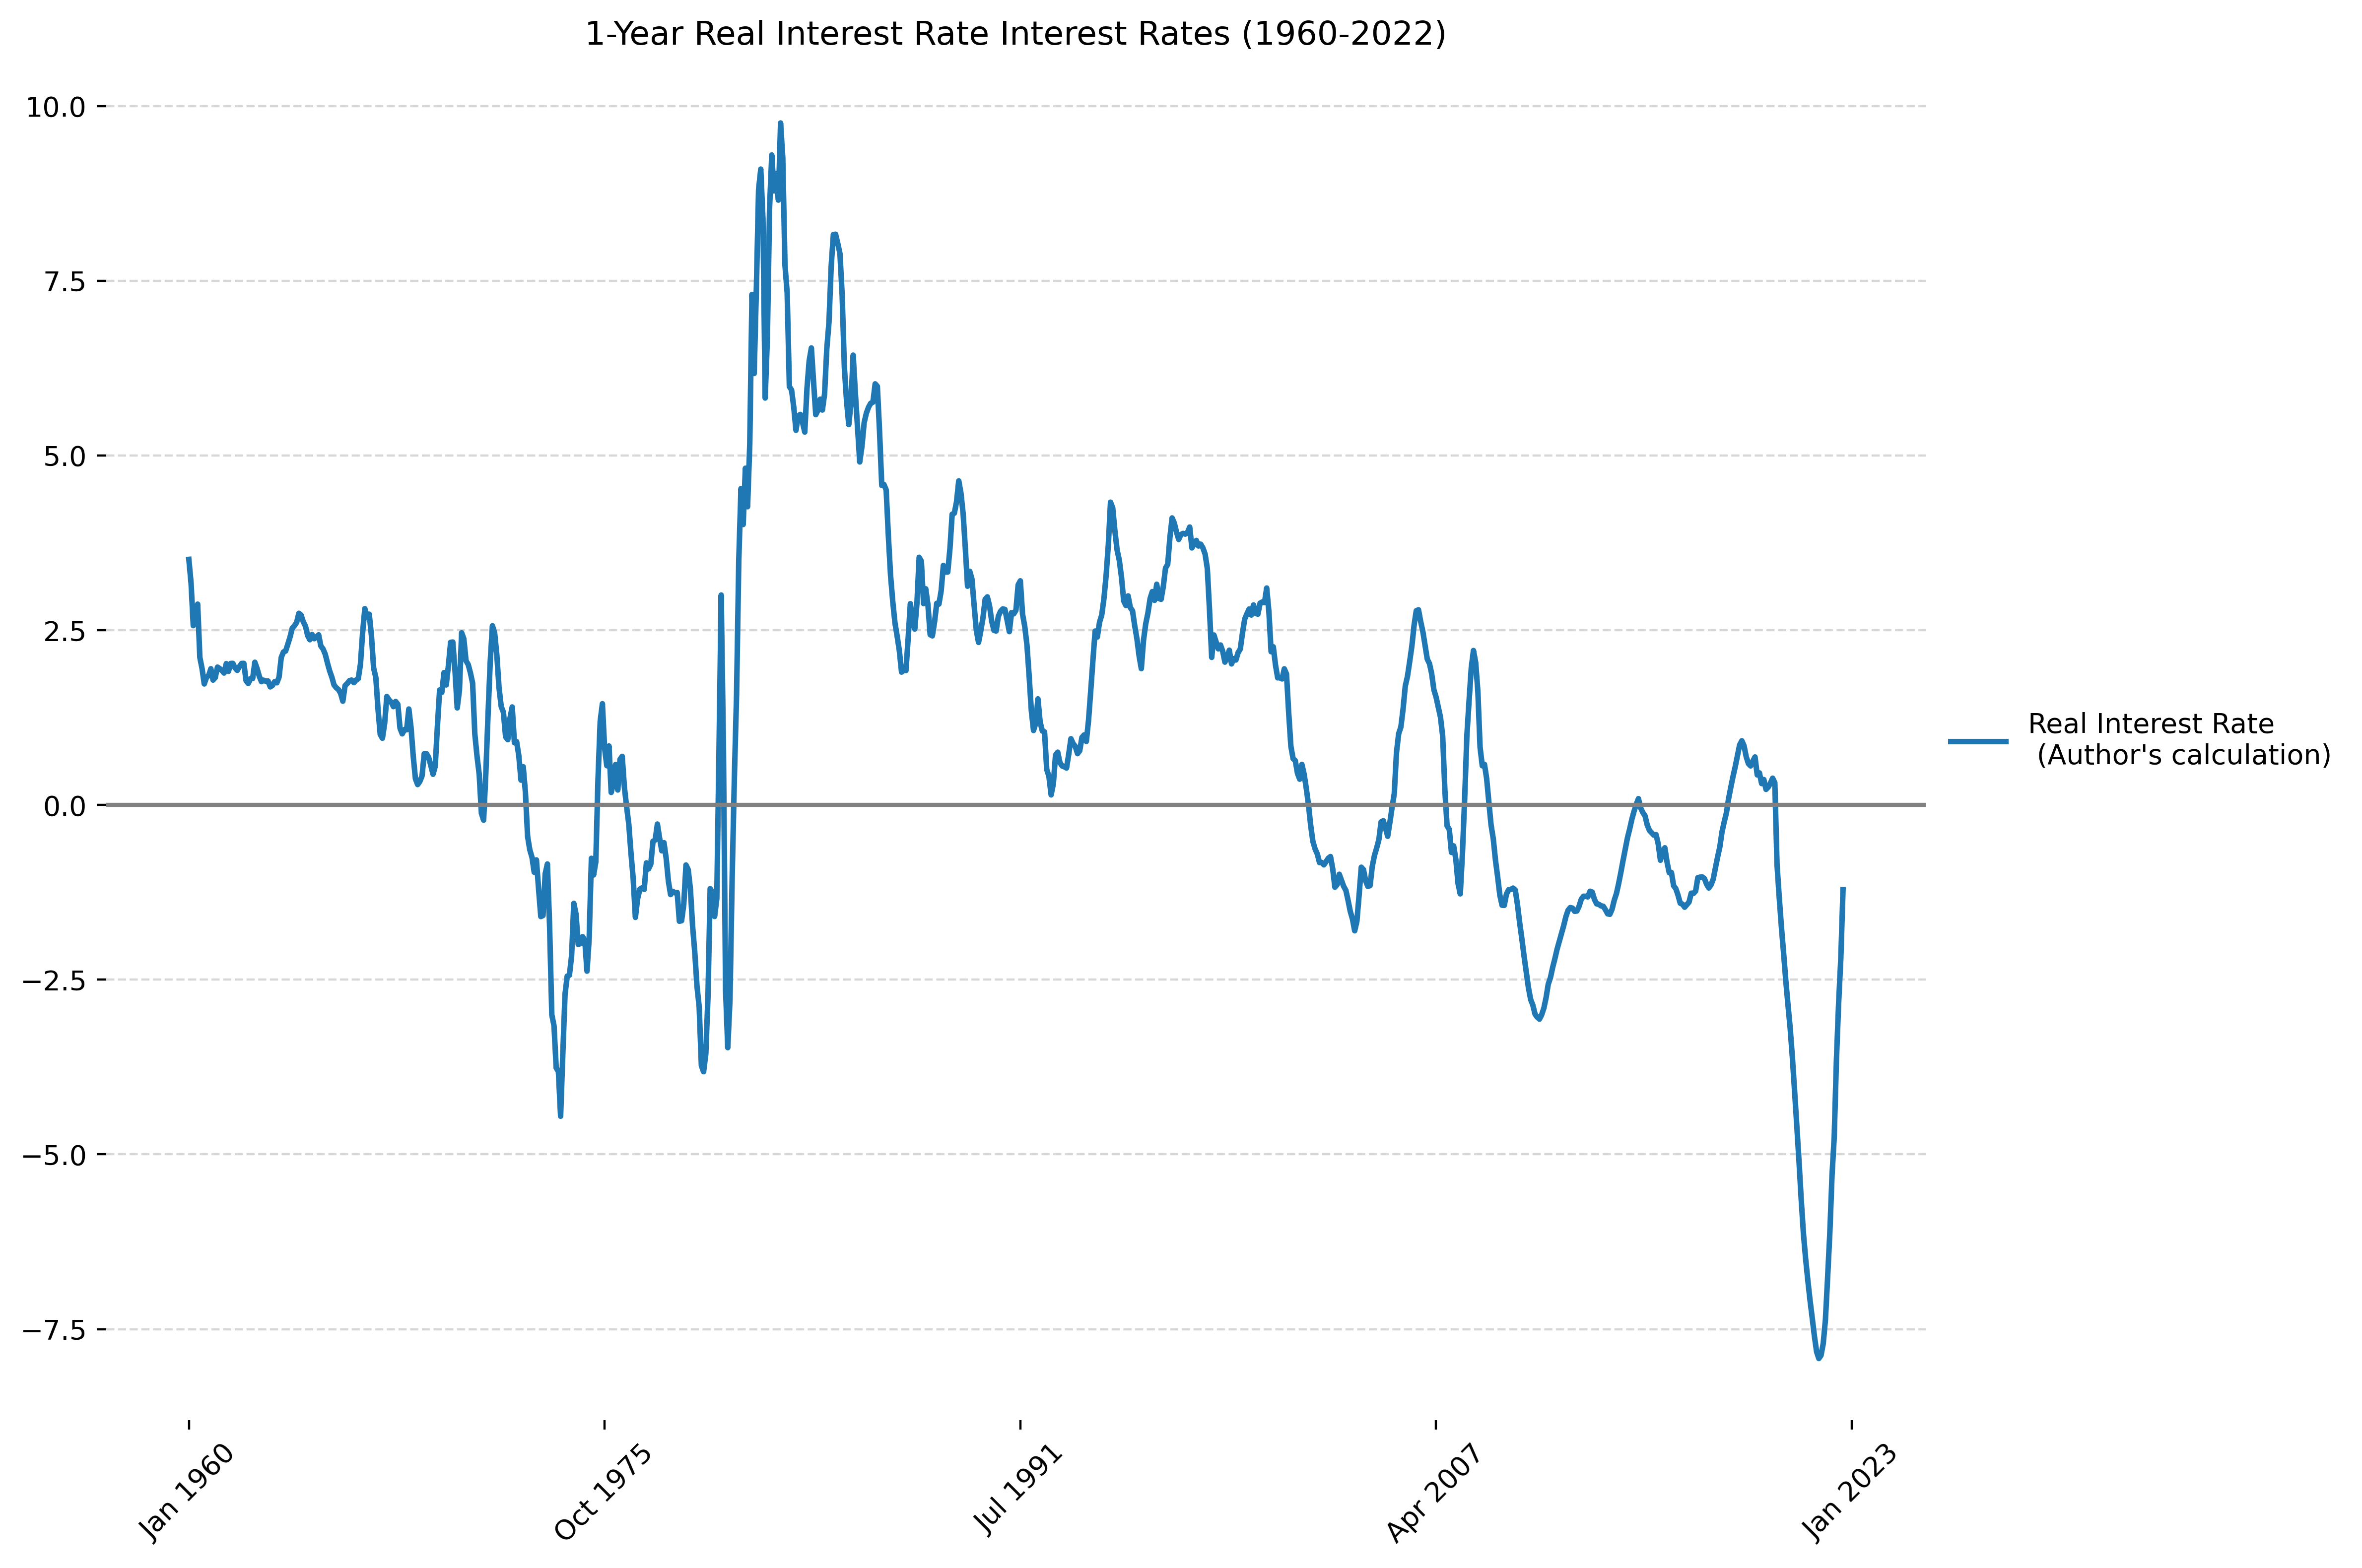

In [46]:
start = datetime.datetime(1953, 4, 1)
end = datetime.datetime(2023, 1, 1)

fig, ax = plt.subplots(figsize=(12, 8), dpi=400)

Y1_real_rate = generate_single_series('GS1', '', CPI_df['US'], 12, start, end, '1-Year Real Interest Rate Interest Rates (1960-2022)', ax)

plt.tight_layout()
plt.show()

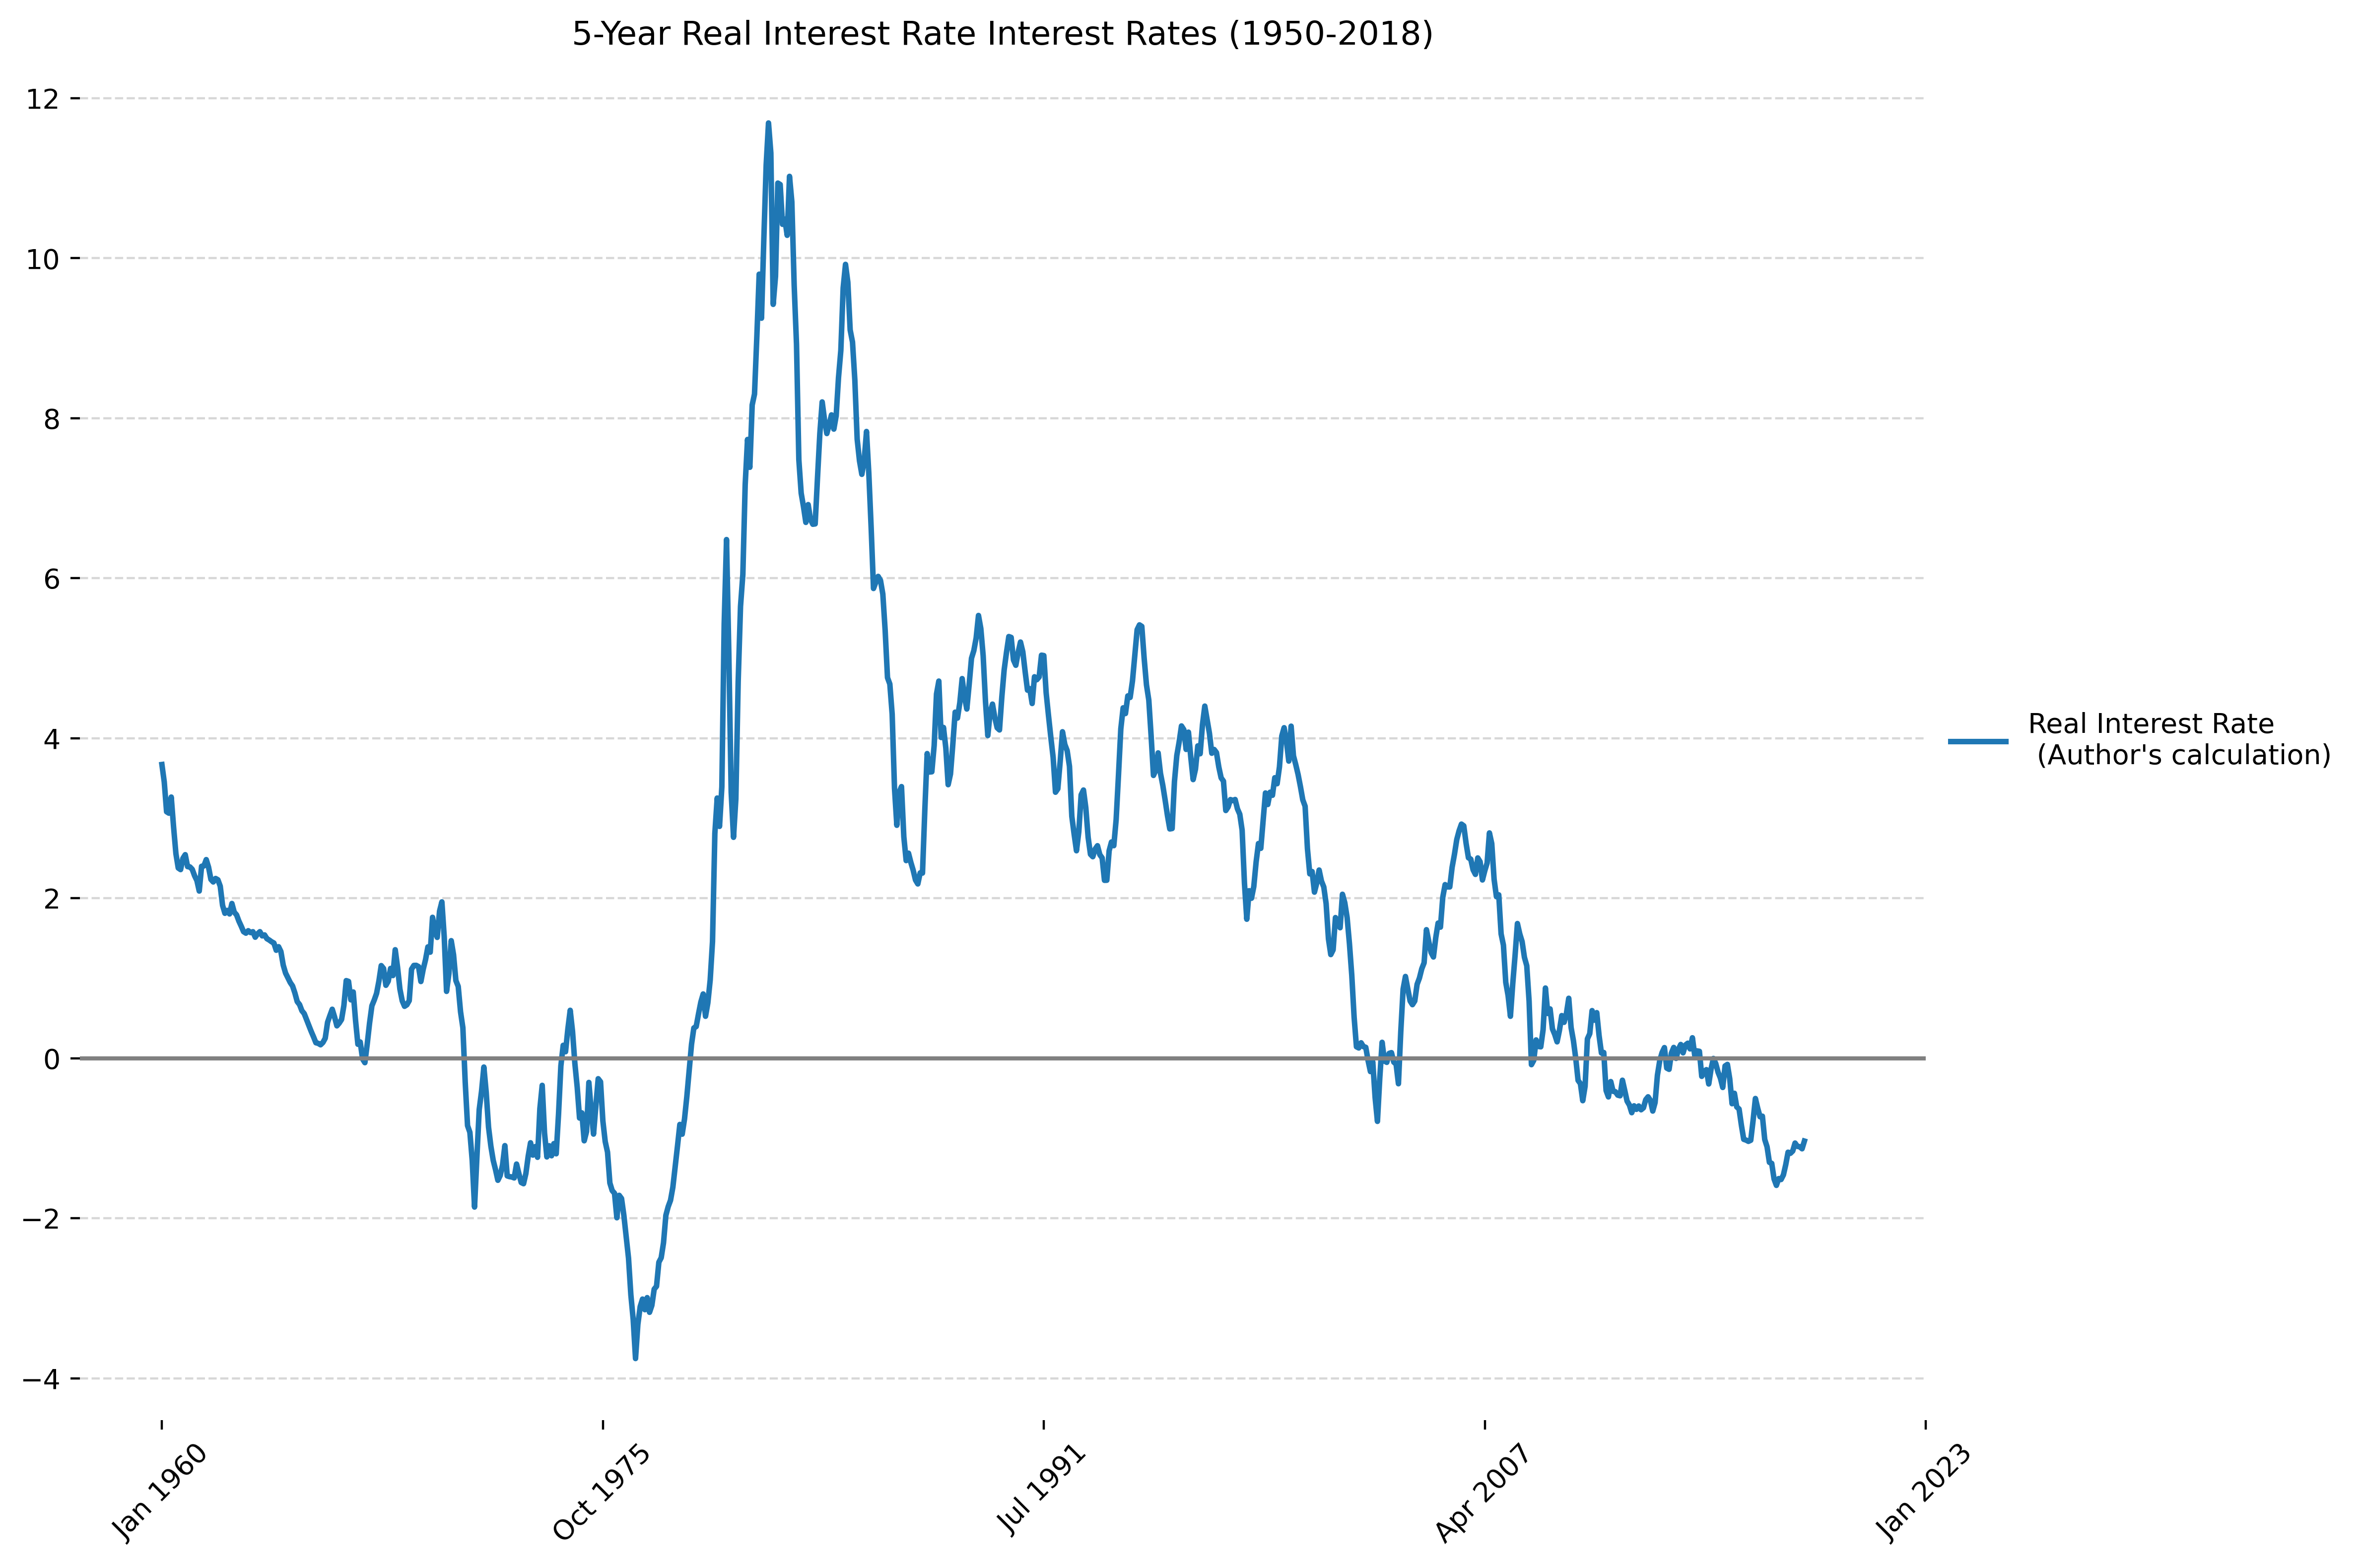

In [47]:
fig, ax = plt.subplots(figsize=(12, 8), dpi=400)

Y5_real_rate = generate_single_series('GS5', '', CPI_df['US'], 60, start, end, '5-Year Real Interest Rate Interest Rates (1950-2018)', ax)

plt.tight_layout()
plt.show()

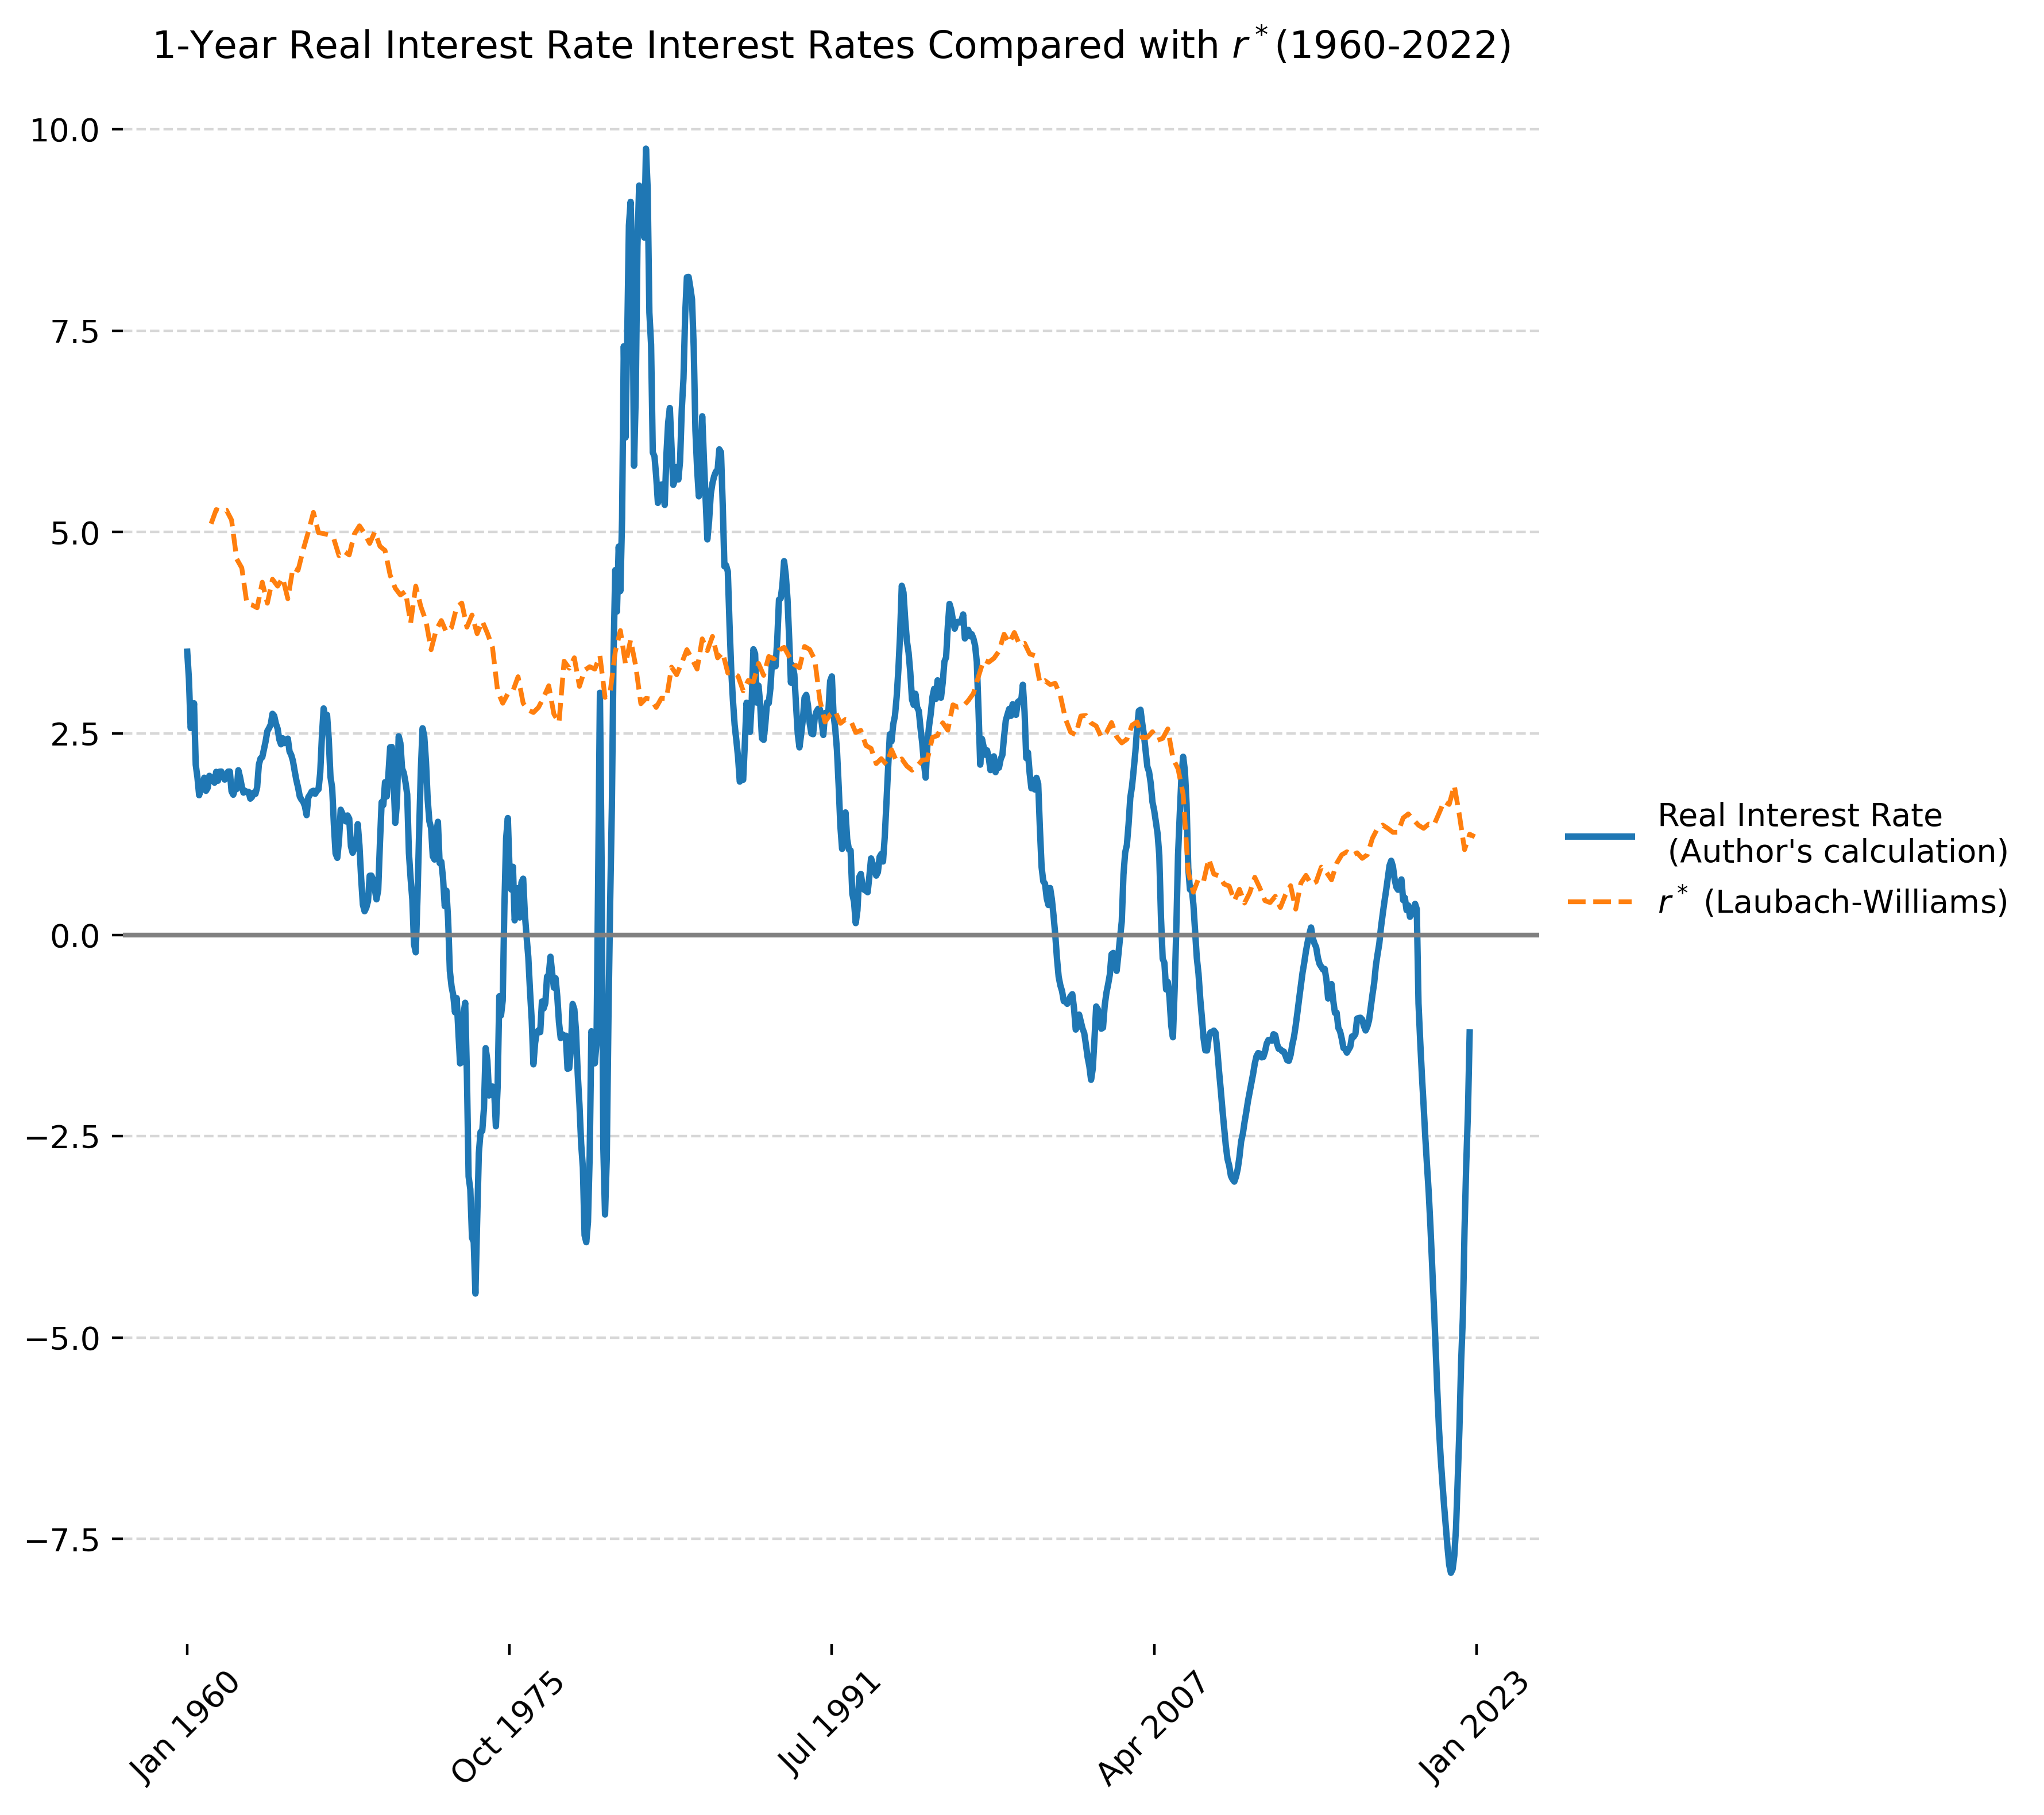

In [48]:
start = datetime.datetime(1953, 4, 1)
end = datetime.datetime(2023, 1, 1)

r_star_df = pd.read_excel('data/Laubach_Williams_current_estimates.xlsx', skiprows=5)
GS1_df = pd.read_csv('data/GS1.csv', parse_dates=True)

GS1_df['DATE'] = pd.to_datetime(GS1_df['DATE']).dt.strftime('%b %Y')
r_star_df['Date'] = pd.to_datetime(r_star_df['Date']).dt.strftime('%b %Y')
merged_df = pd.merge(GS1_df, r_star_df, left_on='DATE', right_on='Date', how='inner')
merged_df = merged_df[['DATE', 'GS1', 'rstar']]

start = datetime.datetime(1953, 4, 1)
end = datetime.datetime(2023, 1, 1)

fig, ax = plt.subplots(figsize=(9, 8), dpi=400)

Y1_real_rate = generate_single_series('GS1', '', CPI_df['US'], 12, start, end, rf'1-Year Real Interest Rate Interest Rates Compared with $r^*$(1960-2022)', ax)

ax.plot(merged_df['DATE'], merged_df['rstar'], label=fr'$r^*$ (Laubach-Williams)', linestyle='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False) 
plt.tight_layout()
plt.show()


## Central Questions

- Why do they go up and down over the business cycle (**Decide whether we want to discuss short-run oscillations**)?

- Why do central banks raise interest rates to fight inflation?

- Why was there a long term trend downward in interest rates?


## Potential Reasons for Declining Long-term Trend

Potential Reseason for the declining long-term trend in real interest rates are: 

### Demographics:
- As baby boomers got older, they needed to save for the retirement under incomplete market.
- Less younger people leads to less innovation

### distribution of wealth
- Again, under incomplete market, agents think larger idyosyncratic shock. As a result, they will increase precautionary savings.

### Political economy
- The more older people, the more the policy are favorable to older, which may not be good for future growth.


